This dataset has been found online but there is no credible source and suggestions it has been artificially made.  This notebook is to show the process I would go through when dealing with data to create a machine learning model

   Unnamed: 0        ph    Hardness        Solids  Chloramines     Sulfate  \
0           0       NaN  204.890455  20791.318981     7.300212  368.516441   
1           1  3.716080  129.422921  18630.057858     6.635246         NaN   
2           2  8.099124  224.236259  19909.541732     9.275884         NaN   
3           3  8.316766  214.373394  22018.417441     8.059332  356.886136   
4           4  9.092223  181.101509  17978.986339     6.546600  310.135738   

   Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
0    564.308654       10.379783        86.990970   2.963135           0  
1    592.885359       15.180013        56.329076   4.500656           0  
2    418.606213       16.868637        66.420093   3.055934           0  
3    363.266516       18.436524       100.341674   4.628771           0  
4    398.410813       11.558279        31.997993   4.075075           0  
Null data (percent): 
ph                 15.0
Hardness            0.0
Solids           

<AxesSubplot:>

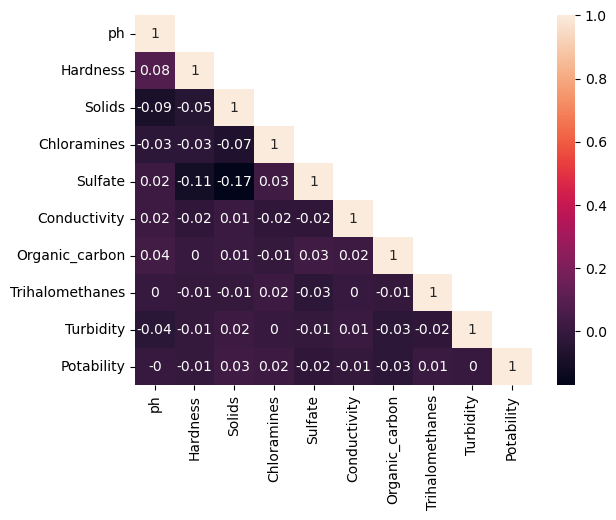

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

water = pd.read_csv("water_potability.csv")

#view information on the imported data 
print(water.head())
water.drop("Unnamed: 0", axis=1, inplace=True)
print(f"Null data (percent): \n{round(100*water.isnull().sum()/water.shape[0],1)}\n")
print("Rows with missing data:\n", water.isna().sum(axis=1).value_counts(), "\n")

#view if there is any correlation between the fields
mask = np.triu(np.ones_like(water.corr()),k=1)
sns.heatmap(round(water.corr(),2), mask=mask, annot=True)

It looks as if there is no correlation between the data.  There are only 3 columns with data missing, so check between the rows with missing values to see if the points with missing data are linked at all (this could depend on collection methods).  If they are linked it will help with imputing the data

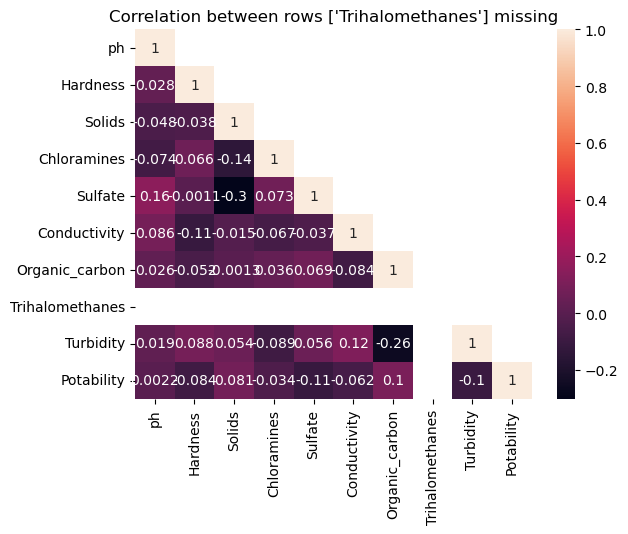

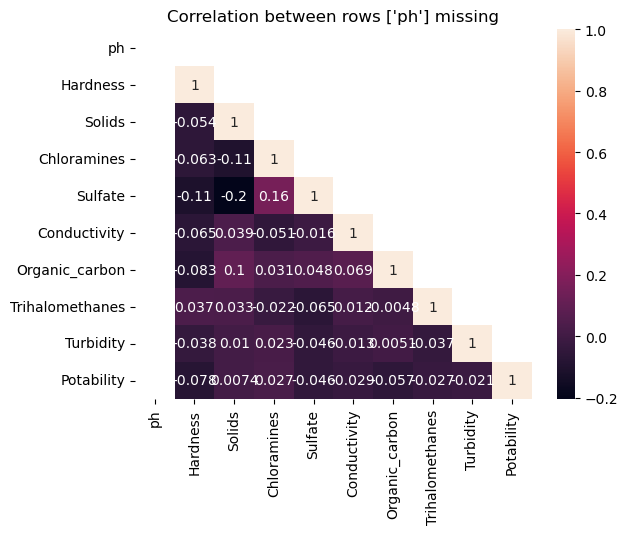

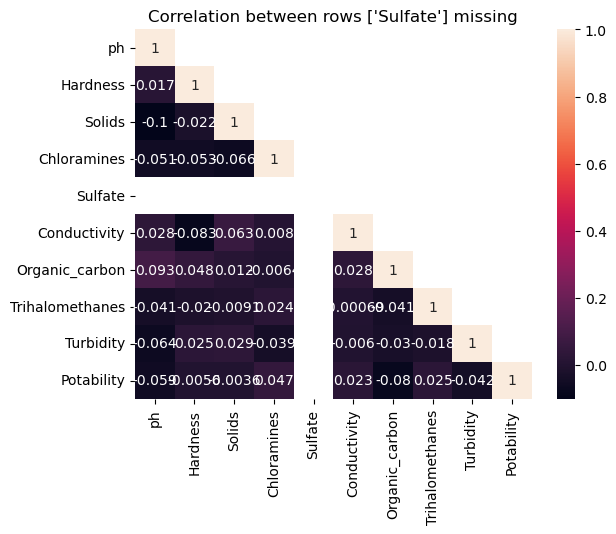

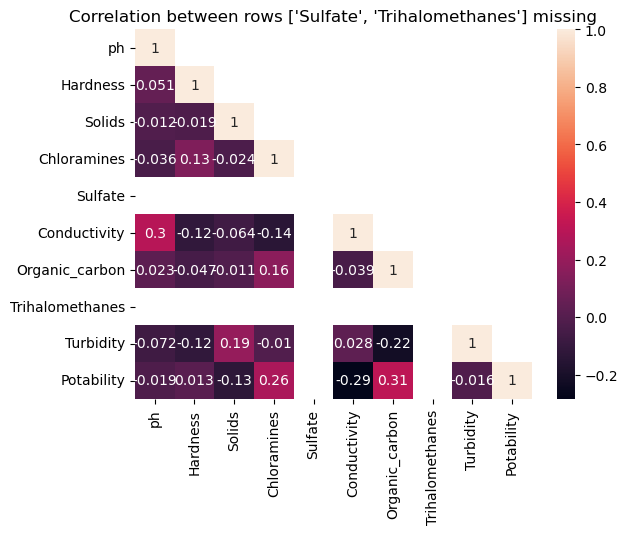

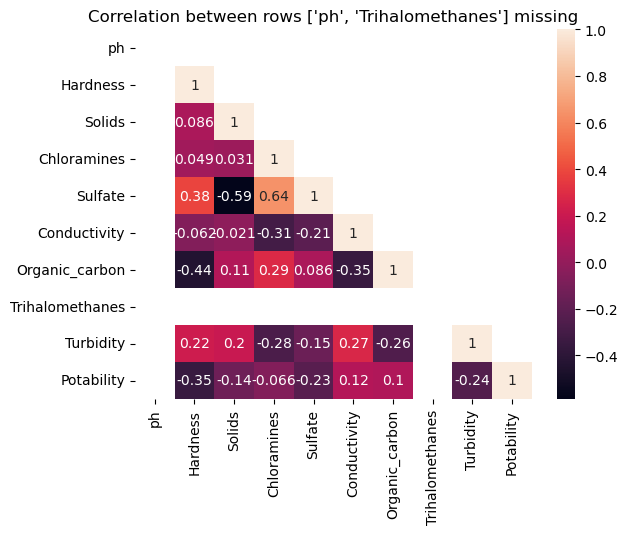

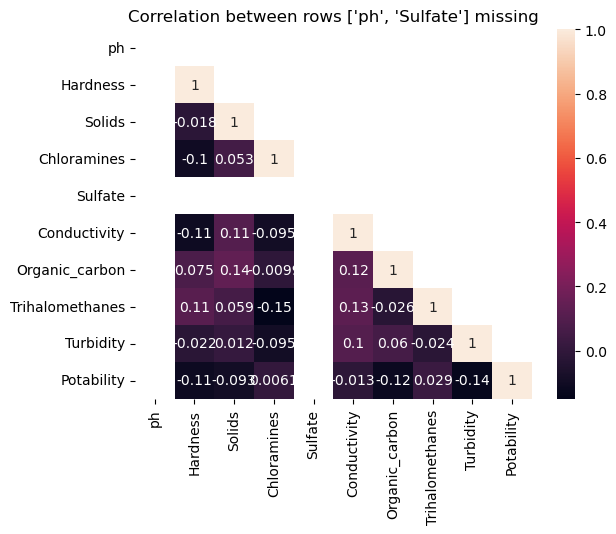

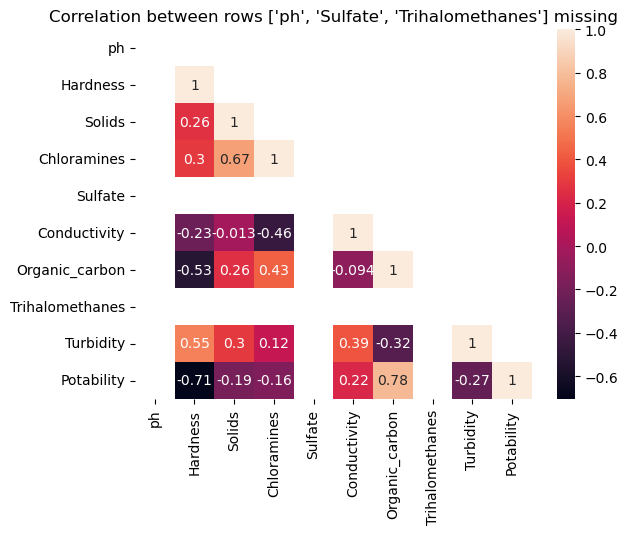

In [2]:
def plot_missing_corr(columns):
    ax = plt.axes()
    missing = water.iloc[np.unique(np.where(water[columns].isna().all(axis=1)))]
    sns.heatmap(missing.corr(),mask=mask, ax=ax, annot=True)
    plt.title(f"Correlation between rows {columns} missing")
    plt.show()
    
#See if there is a large correlation for columns that have certain values missing
plot_missing_corr(["Trihalomethanes"])
plot_missing_corr(["ph"])
plot_missing_corr(["Sulfate"])
plot_missing_corr(["Sulfate","Trihalomethanes"])
plot_missing_corr(["ph","Trihalomethanes"])
plot_missing_corr(["ph","Sulfate"])
plot_missing_corr(["ph","Sulfate","Trihalomethanes"])

Is doesn't look like there is enough correlation to enable multivariate imputation.  Next I will plot a graph to see if there is a normal distrubution for a simple imputer

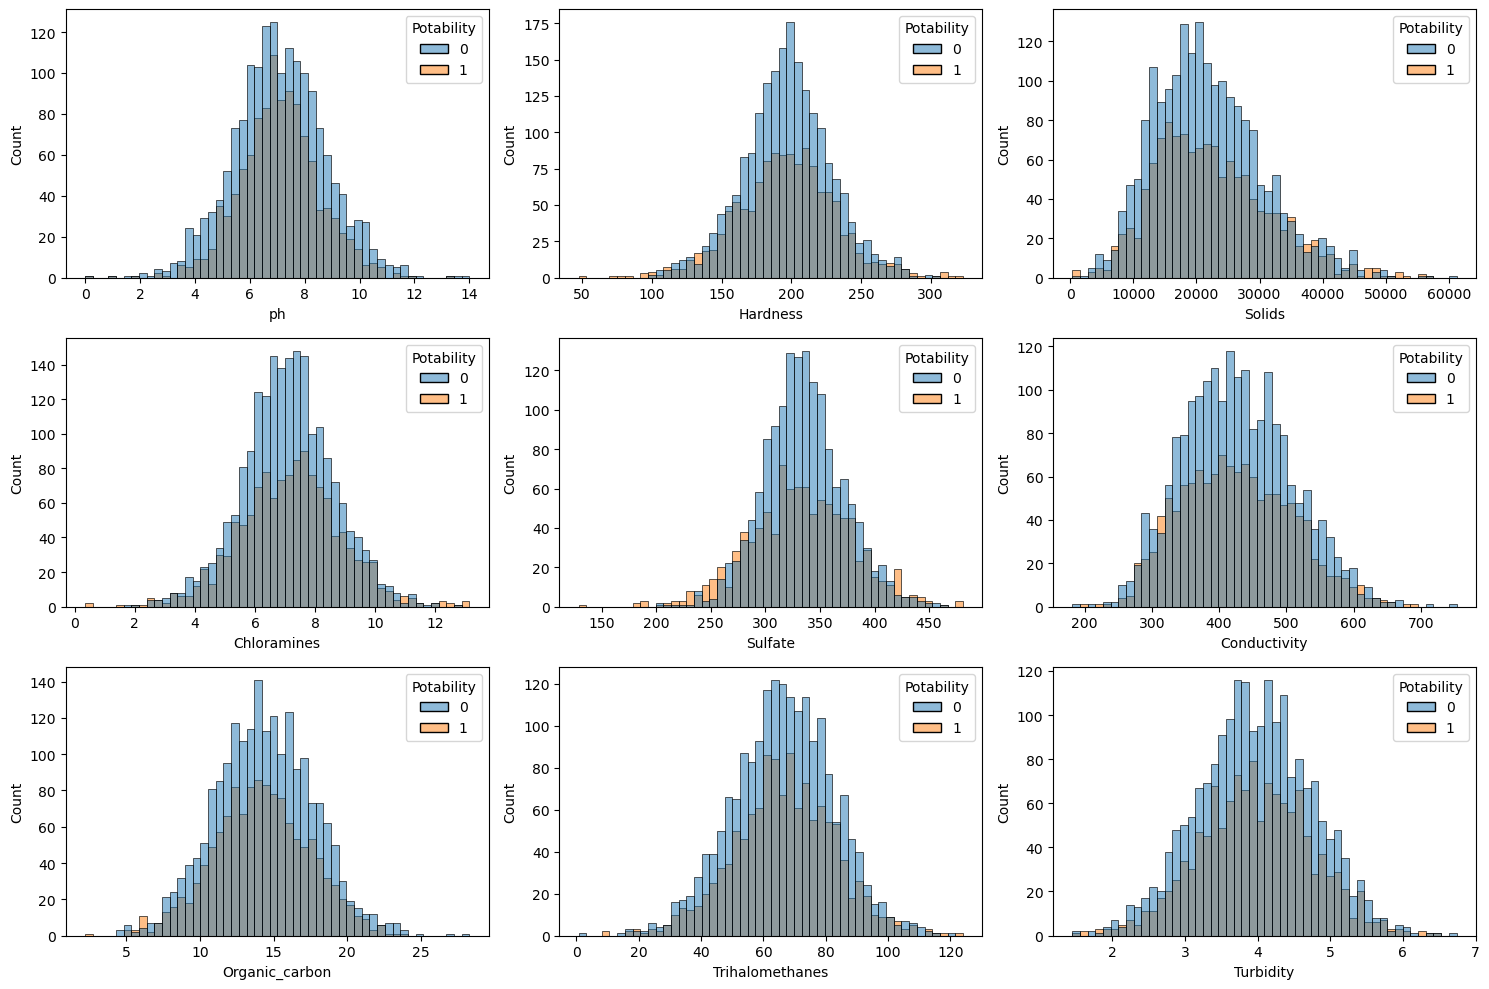

Missing values: 0


In [3]:
#set up a plot with 9 subplots (1 per feature) to view distributions
ncols = 3
nrows = 3
fig, ax = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(15,10)
for i, col in enumerate(water.iloc[:,:-1].columns):
    sns.histplot(data=water, x=col, ax=ax[i//ncols, i%ncols], bins=50, hue="Potability", alpha=0.5)
plt.tight_layout()
plt.show()

#no correlation and follows normal distribution so simple imputer works
imputer = SimpleImputer()
water = pd.DataFrame(imputer.fit_transform(water),columns=water.columns,index=water.index)
print(f"Missing values: {water.isnull().sum().sum()}")

Next we will select a few models are evaluate their base score without any hyperparameter tuning

In [4]:
X_train, X_test, y_train, y_test = train_test_split(water.iloc[:,:-1], water.iloc[:,-1])

models = [("Logistic Regression", LogisticRegression()),
          ("Ridge Classifier", RidgeClassifier()),
          ("SVC", SVC()),
          ("K Neighbours", KNeighborsClassifier()),
          ("Decision Tree", DecisionTreeClassifier()),
          ("Random Forest", RandomForestClassifier()),
          ("Gradient Boosted", GradientBoostingClassifier()),
          ("GaussianNB", GaussianNB()) ]

results = []

#loop through models and add the score to a list
for name, model in models:
    model.fit(X_train,y_train)
    results.append((name, model.score(X_test,y_test)))
    
print(sorted(results, key=lambda x:x[1], reverse=True))

[('Gradient Boosted', 0.6373626373626373), ('Random Forest', 0.6349206349206349), ('GaussianNB', 0.6056166056166056), ('SVC', 0.5946275946275946), ('Decision Tree', 0.5946275946275946), ('Logistic Regression', 0.5934065934065934), ('Ridge Classifier', 0.5934065934065934), ('K Neighbours', 0.5409035409035409)]


We can see that a random forest model is the best, so we will gridsearch to see the best hyperparameters

In [5]:
param_grid = {  "n_estimators":[10,50,100,200],
            "max_features":["sqrt","log2"],
            "max_depth":list(range(1,11)) }

cv = RepeatedStratifiedKFold(n_splits=5)

#set the gridsearch to find the best parameters
clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=cv, n_jobs=5)
clf.fit(X_train, y_train)
print("Best results:", clf.best_score_, "\n", clf.best_params_,"\n")

Best results: 0.6710648585100923 
 {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200} 



Now these features can be put into the random forest model to get an output

In [6]:
#retrain random forest model with the best parameters found from the gridsearch
rf = RandomForestClassifier(**clf.best_params_)
rf.fit(X_train,y_train)
print(f"Score after best feature selection: {rf.score(X_test,y_test)}\n")
print(pd.DataFrame({"Feature":rf.feature_names_in_,"Importance":rf.\
                    feature_importances_}).sort_values("Importance",ascending=False))

Score after best feature selection: 0.6422466422466423

           Feature  Importance
4          Sulfate    0.174960
0               ph    0.157424
1         Hardness    0.128235
2           Solids    0.110185
3      Chloramines    0.108857
6   Organic_carbon    0.083822
5     Conductivity    0.081396
7  Trihalomethanes    0.081198
8        Turbidity    0.073923


The score hasn't improved much since the base level and it doesn't seem like any feature has much importance for further investigation